# Sony Research - Customer Churn Prediction

## Table of Contents
* [Assignment](#Assignment)
* [Data Description](#Data-Description)
* [Question 1](#Question-1)

## Assignment
You are provided with a sample dataset of a telecom company’s customers and it's expected to done the following tasks:

**Question 1:**  Perform exploratory analysis and extract insights from the dataset.

**Question 2:** Split the dataset into train/test sets and explain your reasoning.

**Question 3:** Build a predictive model to predict which customers are going to churn and discuss the reason why you choose a particular algorithm.

**Question 4:** Establish metrics to evaluate model performance.

**Question 5:** Discuss the potential issues with deploying the model into production.

## Data Description

**State:** The state where a customer comes from

**Account length:**	Number of days a customer has been using services

**Area code:** The area where a customer comes from

**Phone number:** The phone number of a customer

**International:** The status of customer international plan

**Voicemail plan:** The status of customer voicemail plan

**No. vmail msgs:** Number of voicemail message sent by a customer

**Total day minutes:** Total call minutes spent by a customer during day time

**Total day calls:** Total number of calls made by a customer during day time

**Total day charge:** Total amount charged to a customer during day time

**Total eve minutes:** Total call minutes spent by a customer during evening time

**Total eve calls:** Total number of calls made by a customer during evening time

**Total eve charge:** Total amount charged to a customer during evening time

**Total night minutes:** Total call minutes spent by a customer during night time

**Total night calls:** Total number of calls made by a customer during night time

**Total night charge:** Total amount charged to a customer during night time

**Total intl minutes:** Total international call minutes spent by a customer

**Total intl calls:** Total number of international calls made by a customer

**Total int charge:** Total international call amount charged to a customer

**Customer service calls:** Total number of customer service calls made by a customer

**Churn:** Whether a customer is churned or not

## Question 1
Perform exploratory analysis and extract insights from the dataset.

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
data = pd.read_csv('Data_Science_Challenge.csv')
data.head(3)

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False


In [17]:
data.shape

(3333, 21)

In [18]:
data.isnull().sum()

state                     0
account length            0
area code                 0
phone number              0
international plan        0
voice mail plan           0
number vmail messages     0
total day minutes         0
total day calls           0
total day charge          0
total eve minutes         0
total eve calls           0
total eve charge          0
total night minutes       0
total night calls         0
total night charge        0
total intl minutes        0
total intl calls          0
total intl charge         0
customer service calls    0
churn                     0
dtype: int64

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

In [20]:
print('Number of unique phone number:' , data['phone number'].nunique())
print('Number of unique area code:' , data['area code'].nunique())
print('Number of unique state:' , data['state'].nunique())

Number of unique phone number: 3333
Number of unique area code: 3
Number of unique state: 51


Other features such as area code (as long as their distinct value amount does not explode the number of variables in the dataset) can be processed with one-hot encoding to create insight for machine learning models. This effort is necessary because if we would remain them as it is, it could misguide the ML model such as having an implicit ordinal relationship between categories.



We will prefer to leave state values out of the dataset in order to not have issues with high dimensionality. We can start to process other categorical features.

In [21]:
area_code_dummies = pd.get_dummies(data['area code'])

# The add_prefix() method inserts the specified value in front of the column label.
area_code_dummies = area_code_dummies.add_prefix('area_code_')

area_code_dummies

,area_code_408,area_code_415,area_code_510
0,0,1,0
1,0,1,0
2,0,1,0
3,1,0,0
4,0,1,0
...,...,...,...
3328,0,1,0
3329,0,1,0
3330,0,0,1
3331,0,0,1


In [22]:
data['voice mail plan'].loc[data['voice mail plan'] == 'no'] = 0

data['voice mail plan'].loc[data['voice mail plan'] == 'yes'] = 1

data['voice mail plan'] = data['voice mail plan'].astype('int64')

data['voice mail plan']

/var/folders/9q/jfjy60yj2tb9g_kpwyt_g0b80000gn/T/ipykernel_1627/3148800439.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['voice mail plan'].loc[data['voice mail plan'] == 'no'] = 0
/var/folders/9q/jfjy60yj2tb9g_kpwyt_g0b80000gn/T/ipykernel_1627/3148800439.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['voice mail plan'].loc[data['voice mail plan'] == 'yes'] = 1


0       1
1       1
2       0
3       0
4       0
       ..
3328    1
3329    0
3330    0
3331    0
3332    1
Name: voice mail plan, Length: 3333, dtype: int64

In [23]:
data['international plan'].loc[data['international plan'] == 'no'] = 0

data['international plan'].loc[data['international plan'] == 'yes'] = 1

data['international plan'] = data['international plan'].astype('int64')

data['international plan']

/var/folders/9q/jfjy60yj2tb9g_kpwyt_g0b80000gn/T/ipykernel_1627/145883522.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['international plan'].loc[data['international plan'] == 'no'] = 0
/var/folders/9q/jfjy60yj2tb9g_kpwyt_g0b80000gn/T/ipykernel_1627/145883522.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['international plan'].loc[data['international plan'] == 'yes'] = 1


0       0
1       0
2       0
3       1
4       1
       ..
3328    0
3329    0
3330    0
3331    1
3332    0
Name: international plan, Length: 3333, dtype: int64

In [25]:
data_final = data.drop(columns = ['phone number', 'state', 'area code'])

#Pandas concat() method is used to concatenate pandas objects such as DataFrames and Series
data_final = pd.concat([data_final, area_code_dummies], axis = 1)

data_final

,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,...,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn,area_code_408,area_code_415,area_code_510
0,128,0,1,25,265.1,110,45.07,197.4,99,16.78,...,91,11.01,10.0,3,2.70,1,False,0,1,0
1,107,0,1,26,161.6,123,27.47,195.5,103,16.62,...,103,11.45,13.7,3,3.70,1,False,0,1,0
2,137,0,0,0,243.4,114,41.38,121.2,110,10.30,...,104,7.32,12.2,5,3.29,0,False,0,1,0
3,84,1,0,0,299.4,71,50.90,61.9,88,5.26,...,89,8.86,6.6,7,1.78,2,False,1,0,0
4,75,1,0,0,166.7,113,28.34,148.3,122,12.61,...,121,8.41,10.1,3,2.73,3,False,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,192,0,1,36,156.2,77,26.55,215.5,126,18.32,...,83,12.56,9.9,6,2.67,2,False,0,1,0
3329,68,0,0,0,231.1,57,39.29,153.4,55,13.04,...,123,8.61,9.6,4,2.59,3,False,0,1,0
3330,28,0,0,0,180.8,109,30.74,288.8,58,24.55,...,91,8.64,14.1,6,3.81,2,False,0,0,1
3331,184,1,0,0,213.8,105,36.35,159.6,84,13.57,...,137,6.26,5.0,10,1.35,2,False,0,0,1


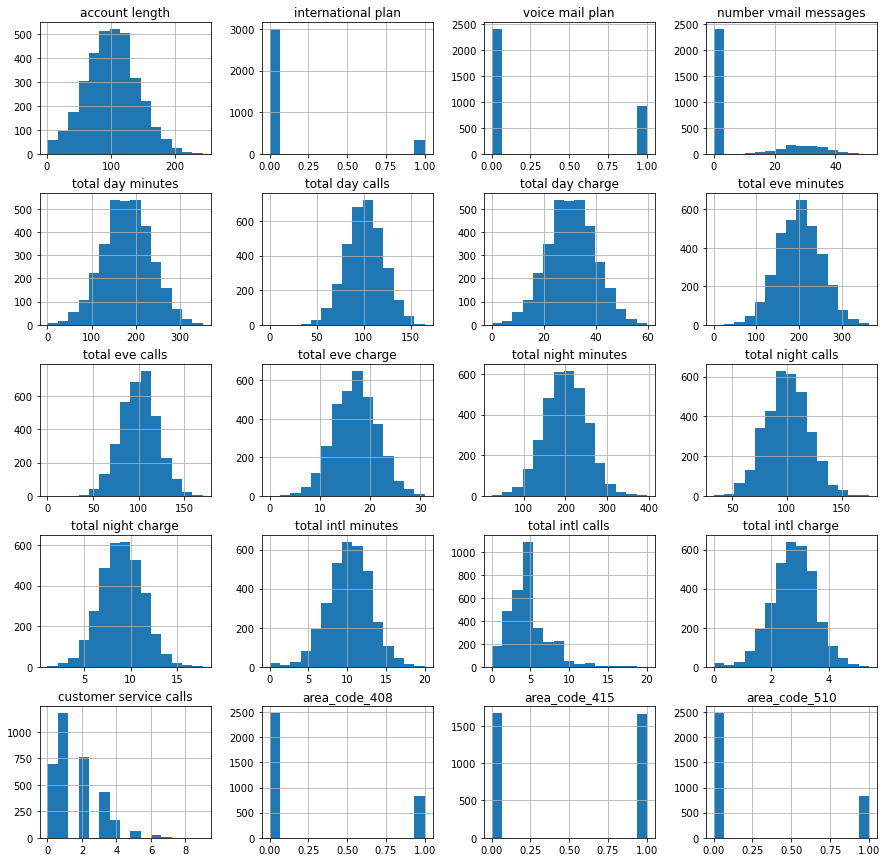

In [29]:
data_final.hist(figsize = (15, 15), bins = 15)
plt.show()

In [31]:
data_final.groupby(['churn'])['churn'].count()

churn
False    2850
True      483
Name: churn, dtype: int64

The distributions tell us:

* Most customers don't use voice mail service and international plans.

* Half of the customers live in area code 415.

* The company earns more by total day calls (check total day charge).

* We have an imbalanced dataset which could be tricky when choosing evaluation metrics.

<AxesSubplot:>

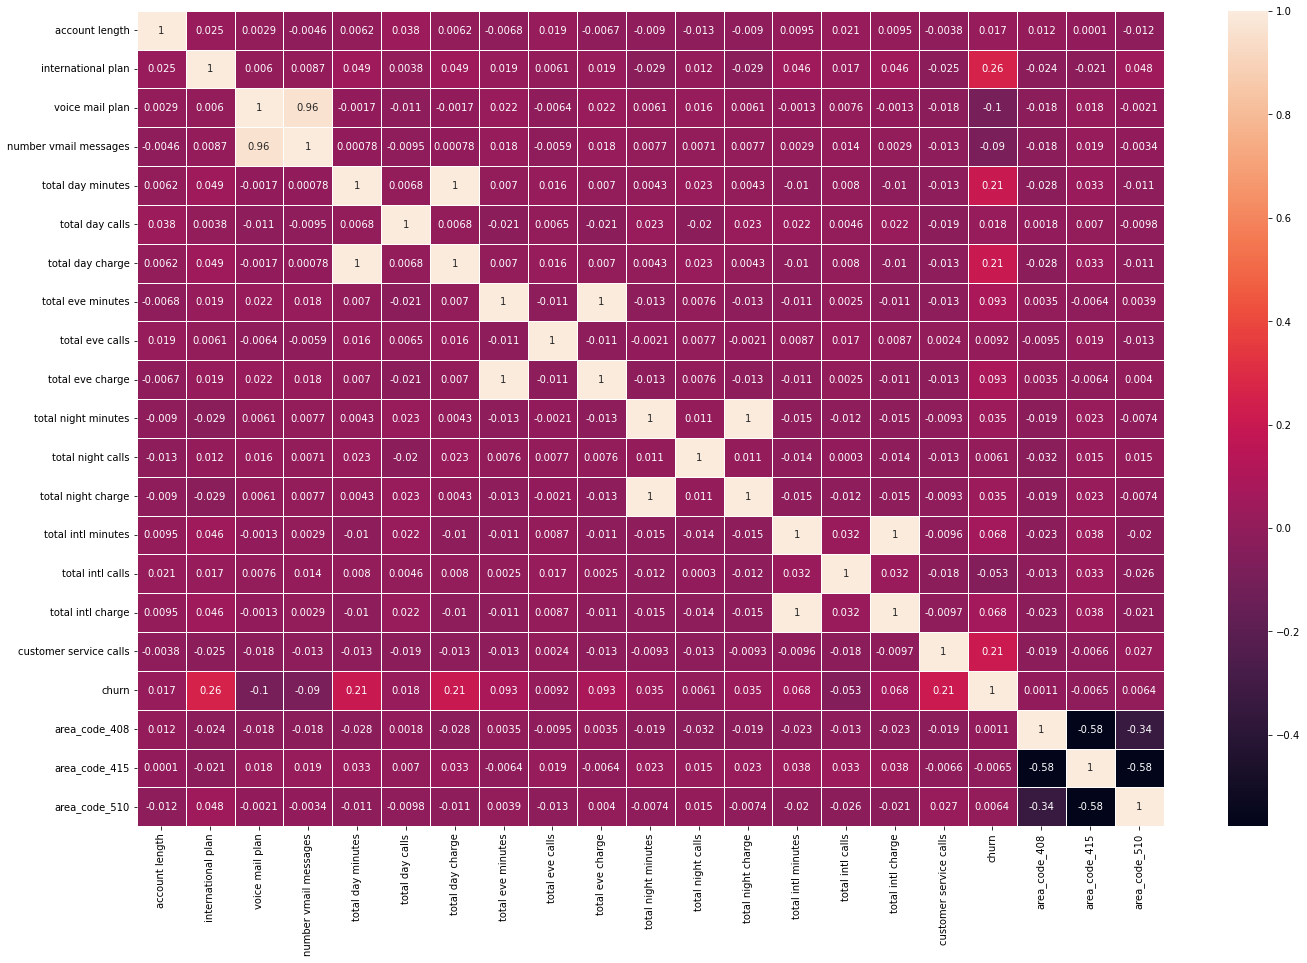

In [41]:
f, ax = plt.subplots(figsize=(23,15))
sns.heatmap(data_final.corr(), annot = True, linewidths = 0.5)

From the correlation matrix, we observe the following things:

There is a positive correlation between:

* total day charge, total day minutes, and churn
* total eve minutes and total eve charge
* total night minutes and total night charge
* total intl minutes and total intl charge
* total customer service calls and churn
* number vmail messages and voice mail
* international plan and churn

There is a negative correlation between:

* churn and voice mail plan
* churn and number vmail messages
* churn and total intl calls
